In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from lxml import etree
import pandas as pd
from tqdm import tqdm
import networkx as nx
import seaborn as sns
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

In [3]:
root = "embryo008"
datapath = Path.cwd().parent / "data"
tracking_path = datapath / "interim" / "tracking" / root
results_path = Path.cwd().parent / "results" / "lineages" / root
results_path.mkdir(parents=True, exist_ok=True)


### Import tracking data and initialize data structures

In [4]:
xml_path = tracking_path / f"{root}_linear.xml"

tree = etree.parse(str(xml_path))

graph = nx.DiGraph()

### Collect spot data and construct graph

240it [00:05, 42.02it/s]
1609it [00:01, 1143.57it/s]


['3470', '3670', '9573', '7347', '21000', '22474', '64695', '64743', '10234', '24155']


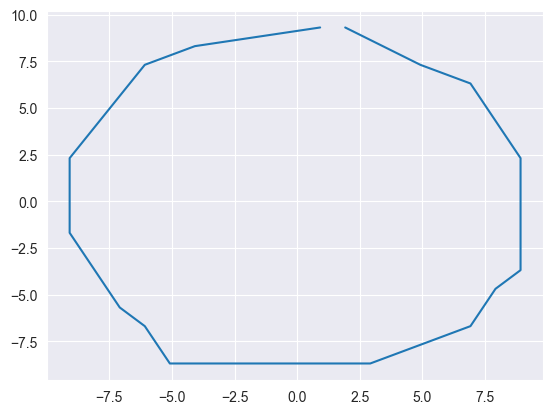

In [5]:
root = tree.getroot()
spots = root.find("Model").find("AllSpots")

# collect spot attributes to dataframe
spots_collect = []

for spot_frame in tqdm(spots.iterchildren()):
    for spot in spot_frame.iterchildren():
        spot_id = spot.get("ID")
        spot_attributes = spot.attrib
        spot_attributes = {key: float(value) for key, value in spot_attributes.items() if key != "name"}
        spot_attributes["ID"] = str(int(spot_id))
        spot_attributes["roi"] = [float(pt) for pt in spot.text.split(" ")]
        spots_collect.append(spot_attributes)
        
spots_df = pd.DataFrame(spots_collect)
            
tracks = root.find("Model").find("AllTracks")

spot_tracks = {idx: 0 for idx in spots_df["ID"]}

for track in tqdm(tracks.iterchildren()):
    track_id = track.get("TRACK_ID")
    for edge in track.iterchildren():
        edge_attributes = edge.attrib
        graph.add_edge(edge_attributes["SPOT_SOURCE_ID"], edge_attributes["SPOT_TARGET_ID"], track_id=track_id)
        spot_tracks[str(int(edge_attributes["SPOT_TARGET_ID"]))] = track_id
        spot_tracks[str(int(edge_attributes["SPOT_SOURCE_ID"]))] = track_id
        
spots_df["track_id"] = [spot_tracks[idx] for idx in spots_df["ID"]]

print(list(graph.nodes)[:10])
pt = spots_df.iloc[0]
plt.plot(pt["roi"][::2], pt["roi"][1::2])

In [6]:
spots_df.head()

,ID,STD_INTENSITY_CH1,SOLIDITY,QUALITY,POSITION_T,TOTAL_INTENSITY_CH1,CONTRAST_CH1,ELLIPSE_MINOR,ELLIPSE_THETA,ELLIPSE_Y0,...,VISIBILITY,RADIUS,POSITION_X,POSITION_Y,ELLIPSE_ASPECTRATIO,POSITION_Z,PERIMETER,ROI_N_POINTS,roi,track_id
0,2304,0.924940,0.994307,265.0,0.0,3930.0,0.987310,9.154600,-1.250816,-0.025534,...,1.0,9.132206,409.584606,510.178117,1.028297,0.0,58.724630,22.0,"[1.915394402035588, 9.321882951654004, 4.91539...",0
1,2562,5.620312,0.972536,303.0,0.0,14553.0,0.982202,9.361854,-1.068897,0.137660,...,1.0,9.788323,810.729236,697.627907,1.144974,0.0,64.635065,23.0,"[2.770764119601381, 9.872093023255843, 4.77076...",1
2,2690,4.590552,0.986139,248.0,0.0,17640.0,0.991967,8.617581,1.533633,-0.037823,...,1.0,8.902761,860.740964,843.886212,1.110507,0.0,57.761902,20.0,"[2.7590361445783174, 9.613788487282477, 5.7590...",2
3,2438,2.266449,0.972222,212.0,0.0,6963.0,0.993641,8.138455,-0.686989,0.125889,...,1.0,8.175884,650.423016,586.715873,1.048733,0.0,53.928724,22.0,"[4.07698412698403, 7.784126984127056, 5.076984...",3
4,2695,6.377946,0.994275,262.0,0.0,18907.0,0.992293,9.054412,1.540508,0.004836,...,1.0,9.106027,969.776392,849.569098,1.047380,0.0,58.459648,21.0,"[3.7236084452974865, 8.930902111324372, 5.7236...",4


### Essential spot analysis

In [7]:
## REMOVE OUTLIER SPOTS and collect distance from edge (hull) for each spot

from src.utils.tracklets import compute_edge_distance, detect_positional_outliers, peak_identification

# remove positional outliers
print(len(spots_df))
# spots_df["position_cluster"] = detect_positional_outliers(spots_df)
# largest_cluster = spots_df.groupby("position_cluster").size().idxmax()
# spots_df = spots_df[spots_df["position_cluster"] == largest_cluster]
print(len(spots_df))
spots_df["distance_from_edge"] = compute_edge_distance(spots_df)

124641
124641


<Axes: xlabel='start_time', ylabel='edge_distance'>

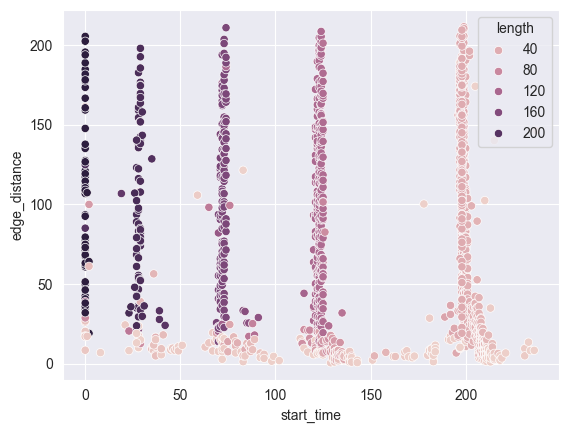

In [8]:
# track analysis
start_times = spots_df.groupby("track_id")["FRAME"].min()
end_times = spots_df.groupby("track_id")["FRAME"].max()
start_id = spots_df.groupby("track_id")["ID"].first()
length = end_times - start_times
edge_distance = spots_df.groupby("track_id")["distance_from_edge"].mean()
end_x = spots_df.groupby("track_id")["POSITION_X"].last()
end_y = spots_df.groupby("track_id")["POSITION_Y"].last()

tracklets = pd.DataFrame({"start_time": start_times, "end_time": end_times, "edge_distance": edge_distance, "end_x": end_x, "end_y": end_y, 
                          "length": length, "start_id": start_id})

# determine division times
n_clusters = 5
peaks = sorted(peak_identification(tracklets[tracklets["edge_distance"] > 50]["start_time"])[:n_clusters])
interphase_dividers = [(p1 + p2) / 2 for p1, p2 in zip(peaks, peaks[1:])]
interphase_dividers.append((end_times.max() + peaks[-1])/2)

sns.scatterplot(tracklets, x="start_time", y="edge_distance", hue="length")

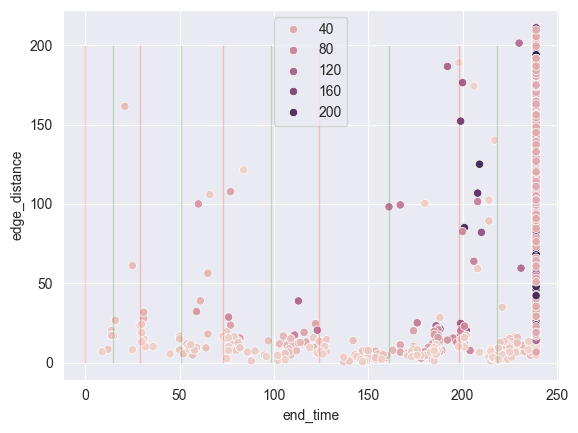

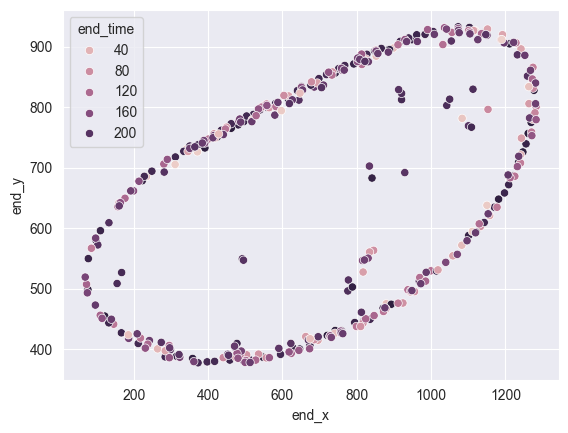

In [9]:
# verify that all track ends are from moving out of focus, false detections, or end of movie (tracks do not end at cell divisions)

sns.scatterplot(tracklets, x="end_time", y="edge_distance", hue="length")
for x in peaks:
    sns.lineplot(x=[x, x], y=[0, 200], color="red")
for x in interphase_dividers:
    sns.lineplot(x=[x, x], y=[0, 200], color="green")
plt.savefig(results_path / "track_ends.png")
plt.show()
non_end = tracklets[tracklets["end_time"] < tracklets["end_time"].quantile(0.9)]
sns.scatterplot(x=non_end["end_x"], y=non_end["end_y"], hue=non_end["end_time"])
plt.savefig(results_path / "track_end_locations.png")
plt.show()

In [10]:
plot_stairs = False

if plot_stairs:
    
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    
    for division, ax in enumerate(axes.flatten()):
        nc = f"Nuclear Division {division + 10}"
        div_start, div_end = interphase_dividers[division], interphase_dividers[division + 1]
        
        division_spots = spots_df[(spots_df["FRAME"] < div_end) & (spots_df["FRAME"] >= div_start)]    
        division_tracklets = tracklets[(tracklets["start_time"] < div_end) & (tracklets["end_time"] > div_end)]
        
        division_fl = division_tracklets[division_tracklets["start_time"] <= div_start]
        division_fl = division_fl[division_fl.index != 0]
        division_sl = division_tracklets[division_tracklets["start_time"] > div_start]
        division_sl = division_sl[division_sl.index != 0]
        
        spots_fl = division_spots[division_spots["track_id"].isin(division_fl.index)]
        spots_sl = division_spots[division_spots["track_id"].isin(division_sl.index)]
        
        first_spots_sl = spots_sl[spots_sl["ID"].isin(division_sl["start_id"])]
        distances = []
    
        for i, spot in first_spots_sl.iterrows():
            earlier_fl_spots = spots_fl[spots_fl["FRAME"] < spot["FRAME"]]
            now_or_later_fl_spots = spots_fl[spots_fl["FRAME"] >= spot["FRAME"]]
            
            # for each track id get last spot from earlier fl spots
            prev_frame_fl_spots = earlier_fl_spots.groupby("track_id").last()
            this_or_next_fl_spots = now_or_later_fl_spots.groupby("track_id").first()
            
            
            # parent_offset
            po_x, po_y = (prev_frame_fl_spots["POSITION_X"] - spot["POSITION_X"]), (prev_frame_fl_spots["POSITION_Y"] - spot["POSITION_Y"])
            # mean_sister_offset
            ms_x, ms_y = (this_or_next_fl_spots["POSITION_X"] - spot["POSITION_X"])/2, (this_or_next_fl_spots["POSITION_Y"] - spot["POSITION_Y"]) / 2
            
            dis = np.sqrt((ms_x - po_x)**2 + (ms_y - po_y)**2)
            dis.replace(np.nan, np.inf, inplace=True)
            
            distances.append(sorted(dis))
    
            
        distances = np.array(distances)
        colors = ["blue", "red"]
        label_val = ["closest neighbor", "second closest neighbor"]
        for k, (color, lab) in enumerate(zip(colors, label_val)):
            edges = sorted(distances[:, k])
            edges.insert(0, 0)
            values = np.arange(1, distances.shape[0] + 1) / distances.shape[0] 
            ax.stairs(values, edges, color=color, label=lab)
        
        ax.set_title(nc)
        ax.set_xlabel("Distance")
        ax.set_ylabel("Proportion of spots")
        ax.legend()
        
    plt.savefig(results_path / f"stairplot.png")
    plt.show()

124425
122816


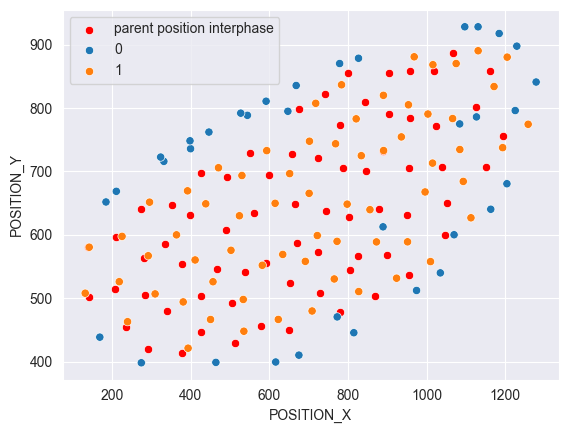

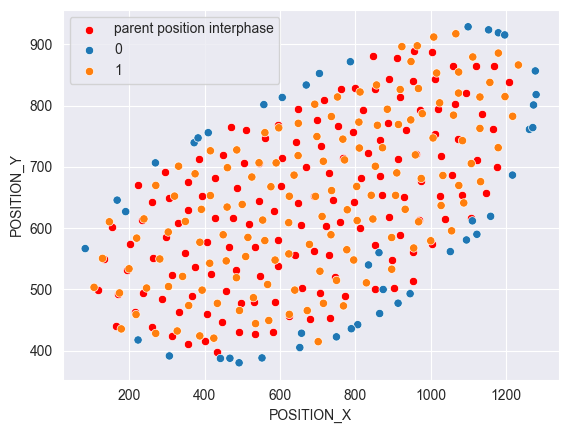

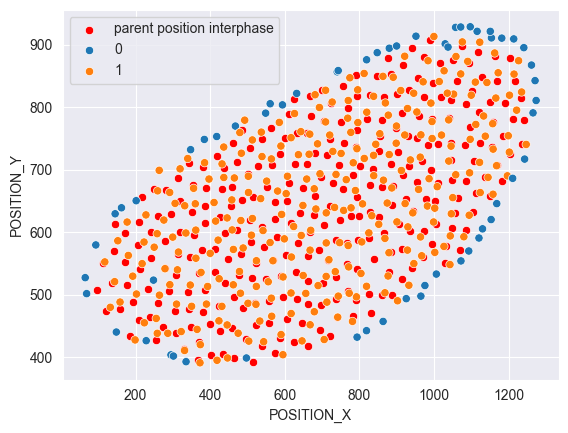

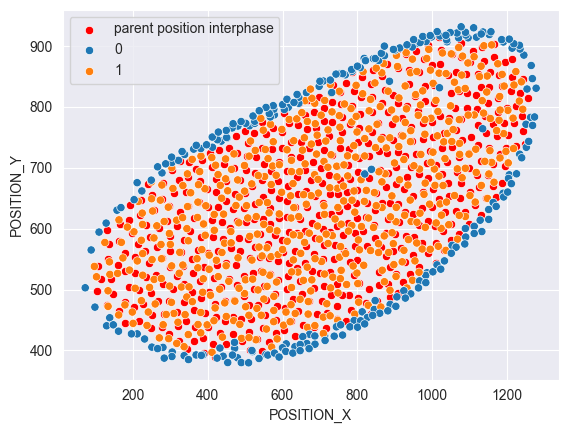

124425
123816


In [11]:
from matplotlib.patches import Circle

distances = [12, 10, 6, 5]

print(len(graph.nodes))
print(len(graph.edges))

for division, d_max in enumerate(distances):
    div_start, div_end = interphase_dividers[division], interphase_dividers[division + 1]
    
    division_spots = spots_df[(spots_df["FRAME"] < div_end) & (spots_df["FRAME"] >= div_start)]    
    division_tracklets = tracklets[(tracklets["start_time"] < div_end) & (tracklets["end_time"] > div_end)]
    
    division_fl = division_tracklets[division_tracklets["start_time"] <= div_start]
    division_fl = division_fl[division_fl.index != 0]
    division_sl = division_tracklets[division_tracklets["start_time"] > div_start]
    division_sl = division_sl[division_sl.index != 0]
    
    spots_fl = division_spots[division_spots["track_id"].isin(division_fl.index)]
    spots_sl = division_spots[division_spots["track_id"].isin(division_sl.index)]
    
    first_spots_sl = spots_sl[spots_sl["ID"].isin(division_sl["start_id"])]
    n_neighbors = []
    for i, spot in first_spots_sl.iterrows():
        earlier_fl_spots = spots_fl[spots_fl["FRAME"] < spot["FRAME"]]
        now_or_later_fl_spots = spots_fl[spots_fl["FRAME"] >= spot["FRAME"]]
        
        # for each track id get last spot from earlier fl spots
        prev_frame_fl_spots = earlier_fl_spots.groupby("track_id").last()
        this_or_next_fl_spots = now_or_later_fl_spots.groupby("track_id").first()
        
        # parent_offset
        po_x, po_y = (prev_frame_fl_spots["POSITION_X"] - spot["POSITION_X"]), (prev_frame_fl_spots["POSITION_Y"] - spot["POSITION_Y"])
        # mean_sister_offset
        ms_x, ms_y = (this_or_next_fl_spots["POSITION_X"] - spot["POSITION_X"])/2, (this_or_next_fl_spots["POSITION_Y"] - spot["POSITION_Y"]) / 2
        
        distance = np.sqrt((ms_x - po_x)**2 + (ms_y - po_y)**2)
        n_neighbors.append((distance < d_max).sum())
        
        if n_neighbors[-1] == 1:
            parent = prev_frame_fl_spots.index[distance < d_max][0]
            # print(prev_frame_fl_spots.loc[parent, "ID"])
            graph.add_edge(str(int(prev_frame_fl_spots.loc[parent, "ID"])), str(int(spot["ID"])))
        elif n_neighbors[-1] >= 2:
            print(f"division {division} spot {spot['ID']} has {n_neighbors[-1]} neighbors")
        
        
    first_spots_fl = spots_fl.groupby("track_id").first()
    sns.scatterplot(x=first_spots_fl["POSITION_X"], y=first_spots_fl["POSITION_Y"], color="red", label="parent position interphase")
    sns.scatterplot(x=first_spots_sl["POSITION_X"], y=first_spots_sl["POSITION_Y"], hue=n_neighbors)
    
    plt.savefig(results_path / f"division_{division}.png")
    plt.show()
    

print(len(graph.nodes))
print(len(graph.edges))

In [12]:
# create new track indices according to the graph

new_track_idx = {idx: 0 for idx in spots_df["ID"]}

for track, c in enumerate(nx.connected_components(graph.to_undirected())):
    for spot in c:
        new_track_idx[spot] = track
        
spots_df["new_track_id"] = [new_track_idx[idx] for idx in spots_df["ID"]]

In [13]:
from skimage.draw import polygon

shape = (round(spots_df["FRAME"].max()) + 1, 1360, 1360)
output_tif = np.zeros(shape, dtype=np.uint16)

for i, spot in tqdm(spots_df.iterrows()):
    x, y = spot["POSITION_X"], spot["POSITION_Y"]
    t = round(spot["FRAME"])
    new_track_id = spot["new_track_id"]
    
    xs = [round(pt + x) for pt in spot["roi"][::2]]
    ys = [round(pt + y) for pt in spot["roi"][1::2]]
    
    rr, cc = polygon(ys, xs, shape[1:])
    output_tif[t, rr, cc] = new_track_id + 1

124641it [00:23, 5244.95it/s]


In [14]:
from tifffile import imwrite

imwrite(results_path / "lineage.tif", output_tif)

In [15]:
spots_df[spots_df["FRAME"] == spots_df["FRAME"].max()].groupby("new_track_id").size().value_counts()

1     181
16     34
2      14
8      11
15      7
3       6
14      5
11      5
12      4
7       3
4       3
13      2
5       2
17      1
10      1
9       1
Name: count, dtype: int64

In [16]:
parents = [node for node in graph.nodes if graph.out_degree(node) == 2]

In [19]:
graph_copy = graph.copy()
for parent in parents:
    children = list(graph.successors(parent))
    for child in children:
        graph_copy.remove_edge(parent, child)

new_tracklet_idx = {idx: 0 for idx in spots_df["ID"]}

for tracklet, c in enumerate(nx.connected_components(graph_copy.to_undirected())):
    for spot in c:
        new_tracklet_idx[spot] = tracklet
        
spots_df["new_tracklet_id"] = [new_tracklet_idx[idx] for idx in spots_df["ID"]]

pd.